In [1]:
# %% [markdown]
# Dual-Field Asymmetric Demo (Direct on Input)

# %%
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)


In [2]:
# %%
def load_sklearn_dataset(name="breast_cancer", test_size=0.3):
    name = name.lower()
    if name == "iris":
        data = datasets.load_iris()
    elif name in ["breast_cancer", "brc", "cancer"]:
        data = datasets.load_breast_cancer()
    elif name == "wine":
        data = datasets.load_wine()
    elif name == "digits":
        data = datasets.load_digits()
    elif name == "moons":
        X, y = datasets.make_moons(n_samples=1000, noise=0.2, random_state=0)
        data = type("D", (), {})()
        data.data = X
        data.target = y
    else:
        raise ValueError(f"Unknown dataset name: {name}")

    X = data.data
    y = data.target

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=123, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test  = torch.tensor(y_test,  dtype=torch.long)

    num_classes = int(y_train.max().item() + 1)
    input_dim = X_train.shape[1]

    return X_train, y_train, X_test, y_test, num_classes, input_dim

DATASET_NAME = "breast_cancer"  # change to "iris", "wine", "digits", "moons"
X_train, y_train, X_test, y_test, num_classes, input_dim = load_sklearn_dataset(DATASET_NAME)

print(f"Dataset: {DATASET_NAME}")
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Input dim: {input_dim}, Num classes: {num_classes}")


Dataset: breast_cancer
Train size: 398, Test size: 171
Input dim: 30, Num classes: 2


In [3]:
# %%
BATCH_SIZE = 64

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

def corrupt_labels(y, noise_rate=0.0, num_classes=None, device=None):
    if noise_rate <= 0.0:
        return y
    if num_classes is None:
        num_classes = int(y.max().item() + 1)
    if device is None:
        device = y.device

    y = y.clone()
    mask = torch.rand_like(y.float(), device=device) < noise_rate
    random_labels = torch.randint(0, num_classes, size=y.shape, device=device)
    y[mask] = random_labels[mask]
    return y


In [4]:
# %%
class DualAsymModule(nn.Module):
    """
    Sample–feature dual-field module with asymmetric coupling:
      S: sample field (B x d)
      F: feature field (D x d)
    Dynamics (T steps):
      S_{t+1} = g(S_t A_s + X F_t W_psi^T)
      F_{t+1} = g(F_t A_f + X^T S_t W_phi^T)
    Internal functional F_int(S,F).
    """
    def __init__(self, D, d=16, T=3,
                 alpha=1.0, beta=1.0, gamma=1.0,
                 nonlin="tanh"):
        super().__init__()
        self.D = D
        self.d = d
        self.T = T
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.A_s = nn.Linear(d, d, bias=False)
        self.A_f = nn.Linear(d, d, bias=False)
        self.W_psi = nn.Linear(d, d, bias=False)  # F -> S
        self.W_phi = nn.Linear(d, d, bias=False)  # S -> F

        if nonlin == "tanh":
            self.g = torch.tanh
        elif nonlin == "relu":
            self.g = F.relu
        else:
            raise ValueError("nonlin must be 'tanh' or 'relu'")

    def forward(self, X):
        B, D = X.shape
        assert D == self.D
        device = X.device

        S = torch.randn(B, self.d, device=device) * 0.1
        F_field = torch.randn(D, self.d, device=device) * 0.1

        X_t = X.t()  # (D x B)

        for _ in range(self.T):
            S_new = self.A_s(S)
            SF = X @ F_field
            SF = self.W_psi(SF)
            S = self.g(S_new + SF)

            F_new = self.A_f(F_field)
            FS = X_t @ S
            FS = self.W_phi(FS)
            F_field = self.g(F_new + FS)

        StS = S.t() @ S
        FtF = F_field.t() @ F_field
        I = torch.eye(self.d, device=device)

        SXT = S.t() @ X
        SXT_F = SXT @ F_field

        term_S = torch.norm(StS - I, p='fro')**2
        term_F = torch.norm(FtF - I, p='fro')**2
        term_align = torch.norm(SXT_F, p='fro')**2

        F_int = - self.alpha * term_S \
                - self.beta  * term_F \
                + self.gamma * term_align

        return S, F_field, F_int


In [9]:
# %% regularizer
class DualAsymDirect(nn.Module):
    """
    Linear classifier on X + dual-field module on X.
    """
    def __init__(self, input_dim, num_classes,
                 d=16, T=3,
                 alpha=1.0, beta=1.0, gamma=1.0):
        super().__init__()
        self.fc_out = nn.Linear(input_dim, num_classes)
        self.dual = DualAsymModule(
            D=input_dim,
            d=d,
            T=T,
            alpha=alpha,
            beta=beta,
            gamma=gamma
        )

    def forward(self, x, detach_fields=True):
        logits = self.fc_out(x)
        if detach_fields:
            X_for_fields = x.detach()
        else:
            X_for_fields = x
        _, _, F_int = self.dual(X_for_fields)
        return logits, F_int


In [10]:
# %%
def train_epoch(model, loader, optimizer, device,
                lambda_phi=0.1, lambda_psi=0.03,
                noise_rate=0.0):
    model.train()
    total_loss = 0.0
    total_ce = 0.0
    total_reg = 0.0
    total_F_int = 0.0
    correct = 0
    total = 0
    n_batches = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_noisy = corrupt_labels(
            y_batch, noise_rate=noise_rate,
            num_classes=num_classes, device=device
        )

        optimizer.zero_grad()
        logits, F_int = model(X_batch)

        ce_loss = F.cross_entropy(logits, y_noisy)
        reg_loss = -lambda_phi * F_int + lambda_psi * F_int
        reg_scaled = reg_loss / (X_batch.size(0) ** 2)

        loss = ce_loss + reg_scaled

        loss.backward()
        optimizer.step()

        batch_size = X_batch.size(0)
        total      += batch_size
        n_batches  += 1

        total_loss += loss.item() * batch_size
        total_ce   += ce_loss.item() * batch_size
        total_reg  += reg_loss.item() * batch_size
        total_F_int += F_int.item()

        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()

    avg_loss  = total_loss / total
    avg_ce    = total_ce / total
    avg_reg   = total_reg / total
    avg_F_int = total_F_int / max(n_batches, 1)
    acc       = 100.0 * correct / total

    return avg_loss, avg_ce, avg_reg, acc, avg_F_int

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits, _ = model(X_batch)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)
    return 100.0 * correct / total


In [11]:
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = DualAsymDirect(
    input_dim=input_dim,
    num_classes=num_classes,
    d=16,
    T=3,
    alpha=1.0,
    beta=1.0,
    gamma=1.0,
).to(device)

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.05,
                            momentum=0.9,
                            weight_decay=1e-4)

NUM_EPOCHS = 30
LAMBDA_PHI = 0.1
LAMBDA_PSI = 0.03
NOISE_RATE = 0.2  # label noise

F_int_history = []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_ce, train_reg, train_acc, avg_F_int = train_epoch(
        model, train_loader, optimizer, device,
        lambda_phi=LAMBDA_PHI,
        lambda_psi=LAMBDA_PSI,
        noise_rate=NOISE_RATE,
    )
    test_acc = eval_epoch(model, test_loader, device)

    F_int_history.append(avg_F_int)

    print(f"Epoch {epoch:02d} | "
          f"Loss {train_loss:.4f} | CE {train_ce:.4f} | Reg {train_reg:.2e} | "
          f"F_int {avg_F_int:.2e} | "
          f"Train Acc {train_acc:.2f}% | Test Acc {test_acc:.2f}%")


Device: cpu
Epoch 01 | Loss -2552.7167 | CE 0.5427 | Reg -1.03e+07 | F_int 1.31e+08 | Train Acc 81.41% | Test Acc 95.91%
Epoch 02 | Loss -2435.0467 | CE 0.5555 | Reg -9.56e+06 | F_int 1.22e+08 | Train Acc 95.73% | Test Acc 97.66%
Epoch 03 | Loss -2415.1184 | CE 0.5145 | Reg -9.62e+06 | F_int 1.23e+08 | Train Acc 94.72% | Test Acc 82.46%
Epoch 04 | Loss -2580.2522 | CE 0.4618 | Reg -1.04e+07 | F_int 1.33e+08 | Train Acc 93.22% | Test Acc 97.08%
Epoch 05 | Loss -2560.2755 | CE 0.4870 | Reg -9.92e+06 | F_int 1.27e+08 | Train Acc 93.72% | Test Acc 97.66%
Epoch 06 | Loss -1902.2664 | CE 0.4023 | Reg -7.51e+06 | F_int 9.60e+07 | Train Acc 95.23% | Test Acc 98.25%
Epoch 07 | Loss -1510.5040 | CE 0.3815 | Reg -6.09e+06 | F_int 7.75e+07 | Train Acc 97.49% | Test Acc 97.66%
Epoch 08 | Loss -2629.0892 | CE 0.3444 | Reg -1.06e+07 | F_int 1.34e+08 | Train Acc 95.98% | Test Acc 97.08%
Epoch 09 | Loss -2425.4598 | CE 0.4349 | Reg -9.29e+06 | F_int 1.19e+08 | Train Acc 97.49% | Test Acc 97.66%
Epoch 1

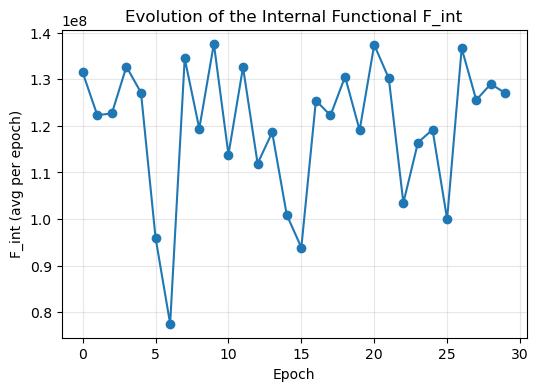

In [12]:
# %%
plt.figure(figsize=(6, 4))
plt.plot(F_int_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F_int (avg per epoch)")
plt.title("Evolution of the Internal Functional F_int")
plt.grid(True, alpha=0.3)
plt.show()
